In [3]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import lightgbm as lgb

from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    KFold,
    StratifiedKFold,
    GroupKFold,
    StratifiedGroupKFold
)

# The Dataset

Stroke prediction data. Using information from patients, predict if they are likely to have a stroke.
- gender, martial status, smoking status, age ...
- also have a "doctor" feature added to reporesent "group" within the data

In [6]:
def get_prep_data():
    data = pd.read_csv(
        "data/healthcare-dataset-stroke-data.csv"
    )
    data["ever_married"] = (
        data["ever_married"].replace("Yes", True).replace("No", False)
    )
    data["gender"] = data["gender"].astype("category")
    data["smoking_status"] = data["smoking_status"].astype("category")
    data["Residence_type"] = data["Residence_type"].astype("category")
    data["work_type"] = data["work_type"].astype("category")
    data["doctor"] = np.random.randint(0, 8, size=len(data))
    holdout_ids = data.sample(n=500, random_state=529).index

    train = (
        data.loc[~data.index.isin(holdout_ids)]
        .sample(frac=1, random_state=529)
        .sort_values("doctor")
        .reset_index(drop=True)
    )
    holdout = (
        data.loc[data.index.isin(holdout_ids)]
        .sample(frac=1, random_state=529)
        .sort_values("doctor")
        .reset_index(drop=True)
    )

    return train, holdout

train, holdout = get_prep_data()

In [8]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,doctor
0,26603,Male,46.0,1,0,True,Self-employed,Urban,101.93,34.0,Unknown,0,0
1,49023,Male,61.0,1,0,True,Self-employed,Rural,102.54,40.5,never smoked,0,0
2,16488,Female,57.0,1,0,True,Private,Urban,210.00,NaN,never smoked,0,0
3,2013,Male,14.0,0,0,False,Private,Rural,110.72,NaN,never smoked,0,0
4,65357,Female,5.0,0,0,False,children,Rural,84.59,17.7,Unknown,0,0


In [9]:
def get_X_y(train):
    FEATURES = [
        "gender",
        "age",
        "hypertension",
        "heart_disease",
        "ever_married",
        "work_type",
        "Residence_type",
        "avg_glucose_level",
        "bmi",
        "smoking_status",
    ]

    GROUPS = "doctor"

    TARGET = "stroke"

    X = train[FEATURES]
    y = train[TARGET]
    groups = train[GROUPS]
    return X, y, groups


In [16]:
X, y, groups = get_X_y(train)
clf = lgb.LGBMClassifier(n_estimators = 100)
clf.fit(X, y)

# predict on the training set for the positive class
pred = clf.predict(X)
pred_prob = clf.predict_proba(X)[:, 1]

In [17]:
acc_score = accuracy_score(y, pred)
auc_score = roc_auc_score(y, pred_prob)
print(f'The score on the training set is accuracy: {acc_score:0.4f} and AUC of {auc_score:0.4f}')

The score on the training set is accuracy: 0.9911 and AUC of 0.9997


# Check on the holdout set!

In [19]:
x_holdout, y_holdout, groups_holdout = get_X_y(holdout)

In [20]:
pred = clf.predict(x_holdout)
pred_prob = clf.predict_proba(x_holdout)[:, 1]
acc_score = accuracy_score(y_holdout, pred)
auc_score = roc_auc_score(y_holdout, pred_prob)
print(f'The score on the training set is accuracy: {acc_score:0.4f} and AUC of {auc_score:0.4f}')

The score on the training set is accuracy: 0.9380 and AUC of 0.7802


## Baseline
Predicting all zeros

In [21]:
accuracy_score(y, np.zeros_like(y)), roc_auc_score(y, np.zeros_like(y))

(0.9516268980477224, 0.5)

Split the data into a training and validation set. Train the model on the training set and validate it on the validation set.
- shuffle: good idea to use to make sure the order isn't impacting the split
- stratified: even distribution of positive samples in each set (when using a small or unbalanced dataset)

In [23]:
X, y, groups = get_X_y(train)

X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.1)

clf = lgb.LGBMClassifier(n_estimators = 100, max_depth=3)
clf.fit(X_tr, y_tr)
pred = clf.predict(X_val)
pred_prob = clf.predict_proba(X_val)[:, 1]
acc_score = accuracy_score(y_val, pred)
auc_score = roc_auc_score(y_val, pred_prob)

print(f'The score on the training set is accuracy: {acc_score:0.4f} and AUC of {auc_score:0.4f}')

The score on the training set is accuracy: 0.9588 and AUC of 0.8429


# Cross Validation!

In [24]:
from matplotlib.patches import Patch
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )


def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=25):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax


def plot_cv(cv, X, y, groups, n_splits=5):
    this_cv = cv(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(15, 5))
    plot_cv_indices(this_cv, X, y, groups, ax, n_splits)

    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)
    plt.show()
    
def get_fake_X_y():
    # Fake Generate the class/group data for an example
    n_points = 100
    X_ = np.random.randn(100, 10)

    percentiles_classes = [0.1, 0.9]
    y_ = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

    # Evenly spaced groups repeated once
    groups_ = np.hstack([[ii] * 10 for ii in range(10)])
    return X_, y_, groups_

### KFold

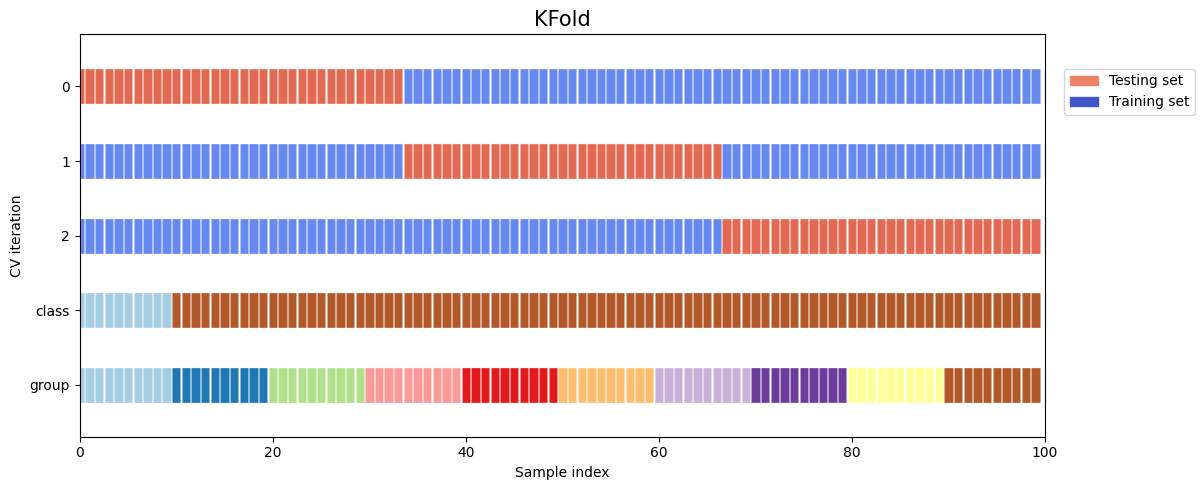

In [31]:
X_, y_, groups_ = get_fake_X_y()
plot_cv(KFold, X_, y_, groups_, n_splits=3)

### Stratified KFold
- KFold but the folds are made by preserving the percentage of samples for each class

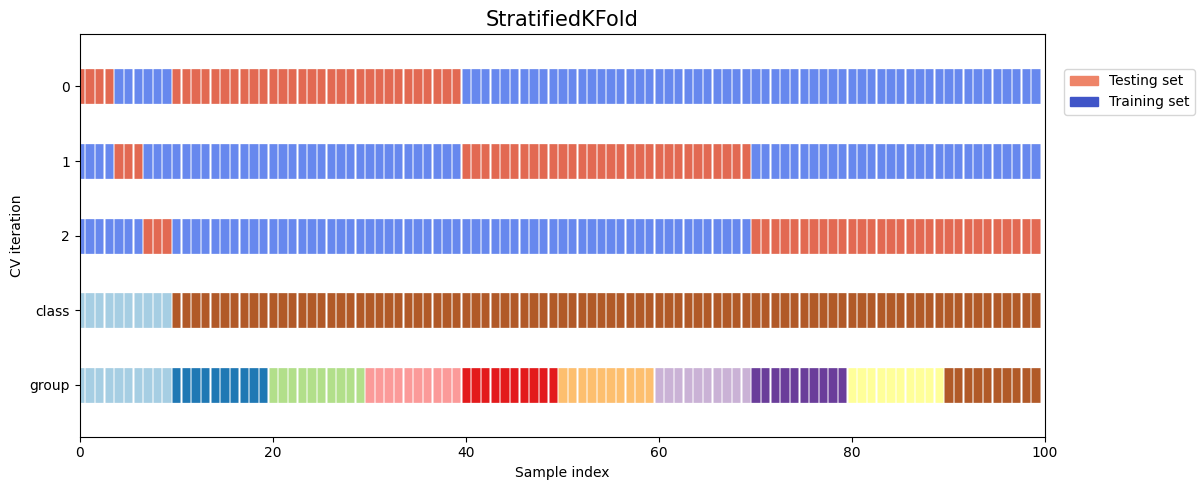

In [32]:
X_, y_, groups_ = get_fake_X_y()
plot_cv(StratifiedKFold, X_, y_, groups_, n_splits=3)

### Group KFold
- The folds are approximately balanced in the sense that the number of distinct groups in apprx the same in each fold

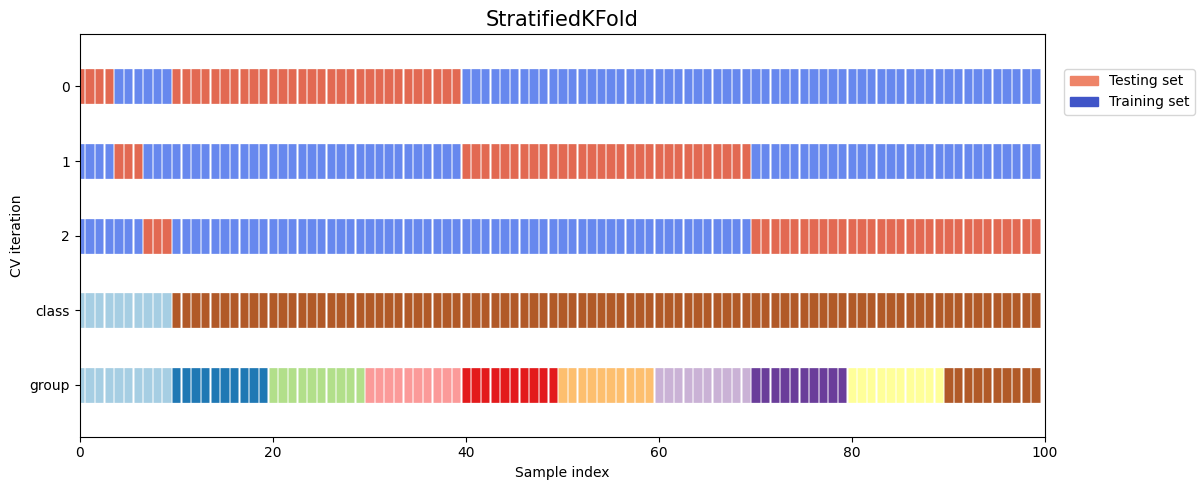

In [32]:
X_, y_, groups_ = get_fake_X_y()
plot_cv(StratifiedKFold, X_, y_, groups_, n_splits=3)

### Stratified Group KFold
- Group fold but preserving the same percentage of samples in each class

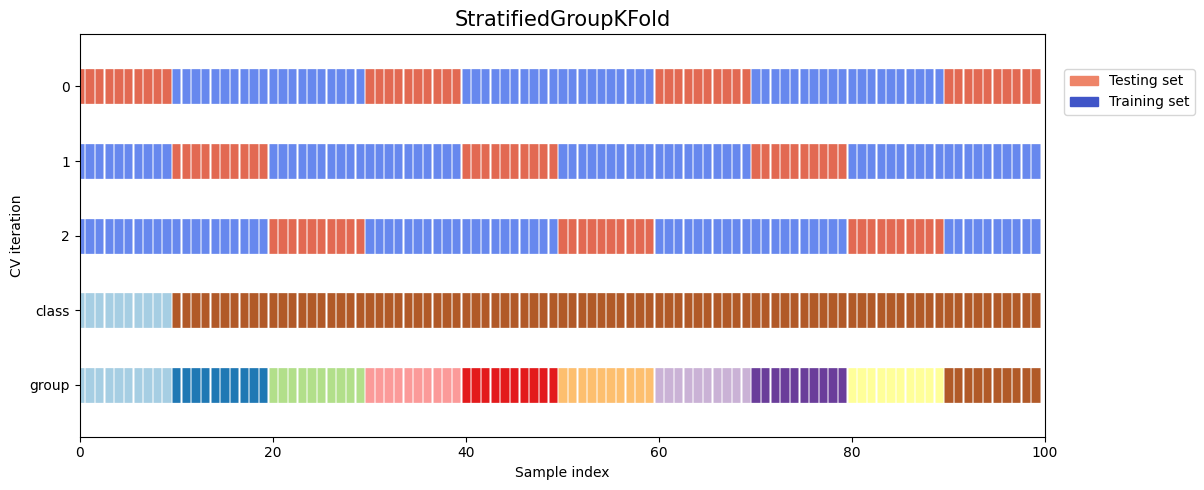

In [34]:
X_, y_, groups_ = get_fake_X_y()
plot_cv(StratifiedGroupKFold, X_, y_, groups_, n_splits=3)

### Time Series Split

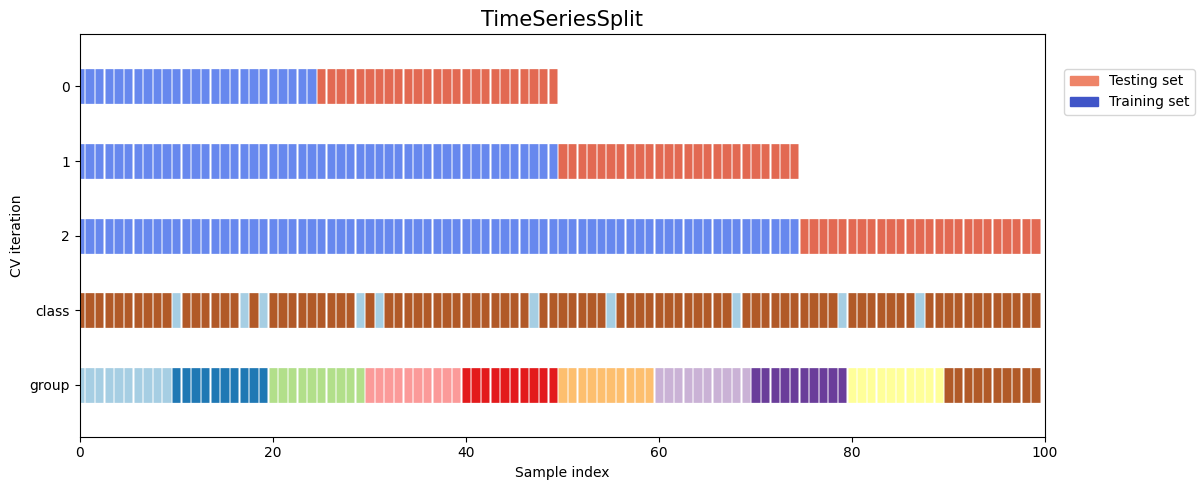

In [35]:
tss = TimeSeriesSplit()
X_, y_, groups_ = get_fake_X_y()
np.random.shuffle(y_)
plot_cv(TimeSeriesSplit, X_, y_, groups_, n_splits=3)

# Our Examaple with proper cross validation
1. Small and imbalanced data -> stratified
2. Group
3. Shuffle on

`StratifiedGroupKFold`

In [41]:
sgk = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=550)

X, y, groups = get_X_y(train)

fold = 0
aucs = []
for train_ind, val_ind in sgk.split(X, y, groups):
    X_tr = X.loc[train_ind]
    y_tr = y.loc[train_ind]
    
    X_val = X.loc[val_ind]
    y_val = y.loc[val_ind]
    
    clf = lgb.LGBMClassifier(n_estimators = 100, max_depth=3)
    clf.fit(X_tr, y_tr)
    pred = clf.predict(X_val)
    pred_prob = clf.predict_proba(X_val)[:, 1]
    acc_score = accuracy_score(y_val, pred)
    auc_score = roc_auc_score(y_val, pred_prob)
    print(f'======= Fold {fold}) =======')
    print(f'The score on the training set is accuracy: {acc_score:0.4f} and AUC of {auc_score:0.4f}')
    fold += 1
    aucs.append(auc_score)
    
print(f'\nOur out of fold AUC score is {np.mean(aucs):0.4f}')

======= Fold 0) =======
The score on the training set is accuracy: 0.9538 and AUC of 0.8748
======= Fold 1) =======
The score on the training set is accuracy: 0.9542 and AUC of 0.8501
======= Fold 2) =======
The score on the training set is accuracy: 0.9477 and AUC of 0.8330
======= Fold 3) =======
The score on the training set is accuracy: 0.9416 and AUC of 0.8499
======= Fold 4) =======
The score on the training set is accuracy: 0.9549 and AUC of 0.8473

Our out of fold AUC score is 0.8510
